## 1. Stohastic block model

### (a) Consider a network with adjacency matrix:
$$
\begin{align*}
A=\begin{bmatrix}
    0 & 1 & 1 & 0 & 0 & 0 & 0 \\
    1 & 0 & 1 & 0 & 0 & 0 & 0 \\
    1 & 1 & 0 & 1 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 1 & 1 & 0 \\
    0 & 0 & 0 & 1 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 & 1 & 0 & 1 \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}
\end{align*}
$$

### and a stohastic block model with block assignment vector $\hat{z}$ = (0, 0, 0, 1, 1, 1, 1). Give a maximum likelihood estimation for the stohastic block matrix M. Is this the vector $\vec{z}$ that maximizes the likelihood function for B = 2?

We have only 2 blocks here: block 0 and block 1. So, lets calculate some quantities.

$Ekl$ - number of links between blocks k and l.
\begin{align*}
E_{kl} &= | \{ (i, j) \in E: z_i = k \text{ and } z_j = l \} |\\
E_{00} &= 3\\
E_{10} &= 1\\
E_{11} &= 4\\
\end{align*}

$C_k$ - number of nodes in block
\begin{align*}
C_k &= |\{ i \in V: z_i = k \}| \\
C_0 &= 3 \\
C_1 &= 4
\end{align*}

$N_{kl}$ - number of possible links between blocks k and l.
\begin{align*}
N_{kl} &= \left\{
\begin{array}{lr}
\binom{C_k}{2} &\textrm{ if } k = l\\
C_k \times C_l & \textrm{ if } k \ne l
\end{array} \right. \\
N_{00} &= 3 \\
N_{10} &= 12 \\
N_{11} &= 6 \\
\end{align*}

The likelihood formula:
\begin{align*}
\mathcal{L}(M, \hat{z}) = P(\hat{z}, M) =\prod_{0 \leq k \leq I \leq B - 1} M_{kl}^{E_{kl}} (1 - M_{kl})^{N_{kl} - E_{kl}}
\end{align*}

The log-likelihood:
\begin{align*}
\log(\mathcal{L}(M, \hat{z})) &= \sum_{0 \leq k \leq I \leq B - 1} E_{kl} \log(M_{kl}) + (N_{kl} - E_{kl})\log(1 - M_{kl})
\end{align*}

Considering that fact that each $E_{kl}$ is independent binomial random variable maximum log-likelihood estimation is particulary tractable for a stochastic blockmodel. Treating the fact that there are no constraints on the $M_{kl}$, the maximum log-likelihood estimate for $M$ is obtained by maximizing each of the marginal likelihood functions.

For each $M_{kl}$:
\begin{align*}
\frac{\partial \log(\mathcal{L}(M_{kl}, \hat{z}))}{\partial M_{kl}} &= 0\\
\frac{E_{kl}}{M_{kl}} - \frac{N_{kl} - E_{kl}}{1 - M_{kl}} &= 0\\
&\Updownarrow\\
\hat{M_{kl}} &= \frac{E_{kl}}{N_{kl}}
\end{align*}

So the whole matrix $M$:
\begin{align*}
\begin{bmatrix}
M_{00} & M_{10} \\
M_{10} & M_{11}
\end{bmatrix}
&=
\begin{bmatrix}
\frac{E_{00}}{N_{00}} & \frac{E_{01}}{N_{01}} \\
\frac{E_{10}}{N_{10}} & \frac{E_{11}}{N_{11}}
\end{bmatrix} =\\
&=
\begin{bmatrix}
\frac{3}{3} & \frac{1}{12} \\
\frac{1}{12} & \frac{4}{6}
\end{bmatrix} =\\
&=
\begin{bmatrix}
1 & 0.8(3) \\
0.8(3) & 0.(6)
\end{bmatrix}
\end{align*}

So, here is the maximum log-likelihood estimation.

Now let`s do it in code:
1. lets find the maximum likelihood estimation 
2. letch check if if the $\hat{z}$ assignment vector maximizes the likelihood function

In [68]:
from enum import Enum
from decimal import *
from collections import Counter

import torch
import numpy as np
import scipy as sp
import pathpyG as pp
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten


sns.set_style("whitegrid")

In [54]:
z = [0, 0, 0, 1, 1, 1, 1]

In [55]:
g = pp.Graph.from_edge_list((
    [0, 1],
    [0, 2],
    [1, 2],
    [2, 3],
    [3, 4],
    [3, 5],
    [4, 5],
    [5, 6]
)).to_undirected()
pp.plot(g, node_color=z)

In [56]:
def estimate_block_matrix(graph, z):
    
    # B is the number of blocks
    B = len(set(z))

    # C[k] counts the number of nodes in block k
    C = Counter(z)

    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))
    for v, w in graph.edges:
        if v <= w:
            E[z[graph.mapping.to_idx(v)],z[graph.mapping.to_idx(w)]] += 1
            # increment count for both directions
            if z[graph.mapping.to_idx(v)] != z[graph.mapping.to_idx(w)]:
                E[z[graph.mapping.to_idx(w)],z[graph.mapping.to_idx(v)]] += 1

    # N[k,l] counts how many links can possibly exist between nodes in block k and l
    N = np.zeros((B,B))

    # calculate number of possible links N[k,l] for all pairs of blocks k, l (see comments above)
    for k in range(B):
        for l in range(B):            
            if k == l:
                N[k,l] = sp.special.binom(C[k] + 1, 2)
            else:
                N[k,l]= C[k] * C[l]

    # estimate block matrix entries by dividing number of observed edges between k, l by number of edges possible between k, l
    M = np.zeros((B,B))
    for k in range(B):
        for l in range(B):
            M[k,l] = E[k,l] / N[k,l]
    return M, E, N

In [57]:
M, _, _ = estimate_block_matrix(g, z)
M

array([[0.5       , 0.08333333],
       [0.08333333, 0.4       ]])

In [58]:
def log(x):
    if x == 0:
        return 0.0
    else:
        return np.log(x)


def SBM_max_likelihood(z, graph: pp.Graph):
    L = 0
    M, E, N = estimate_block_matrix(graph, z)
    for k in range(len(set(z))):
        for l in range(k+1):
            L+= E[k,l] * log(M[k,l]) + (N[k,l] - E[k,l]) * log(1-M[k,l])

    return L, M


def simulated_annealing(network: pp.Graph, B, cooling_slowness = 100, changes_per_iter=1, iterations=1000):
    likelihoods = []
    n = network.N
    z = np.zeros(n, dtype=int)
    for i in range(n):
        z[i] = int(np.random.randint(B))
    l, m = SBM_max_likelihood(z, network)
    l = l

    # we output the cooling temperatures to inspect the cooling schedule
    temperatures = []

    for i in tqdm(range(iterations)):

        t = (1+cooling_slowness)/(i+1+cooling_slowness)

        # randomly change community of random node
        z_new = z.copy()
        z_new[np.random.randint(n)] = int(np.random.randint(B))

        for i in range(changes_per_iter):
            i = np.random.choice(n)
            z_new[i] = np.random.choice(B)
        l_new, m_new = SBM_max_likelihood(z_new, network)
        if l_new >= l or np.random.random() <= np.exp(-(l-l_new)/t):
            z = z_new
            l = l_new

        likelihoods.append(np.exp(l))
        temperatures.append(t)
    return z, likelihoods, temperatures

In [59]:
z_detected, _, _ = simulated_annealing(g, 2, iterations=10000)
z_detected

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:03<00:00, 3189.04it/s]


array([1, 1, 0, 1, 0, 1, 0])

In [60]:
pp.plot(g, node_color=z_detected.tolist())

For the network which does not allow self-loops the ground trooth assignment would have the best result, but we defined here that a network would allow self-loops that is why a configuration changed.

### (b) Consider so-called *micro-canonical stochastic block model* i.e. a generalization of the G(n, m) model in the spirit of the stohastic block matrix, where the block matrix entries $M_{kl}$ give the number of edges randomly generated between nodes in block k and block l rather than link probabilitis. Give an expression for the microstate probability of this model.

The micro-canonical ensemble has the block matrix $M$, where $M_{kl}$ is the number of the links between blocks k and l. For the graph from the previous task the matrix $M$ will look like:
\begin{align*}
\begin{bmatrix}
M_{00} & M_{10} \\
M_{10} & M_{11}
\end{bmatrix}
&=
\begin{bmatrix}
3 & 1 \\
1 & 4
\end{bmatrix}
\end{align*}

Let`s keep $N_{kl}$ as the number as possible links between two blocks l and k.
\begin{align*}
N_{kl} &= \left\{
\begin{array}{lr}
\binom{C_k}{2} &\textrm{ if } k = l\\
C_k \times C_l & \textrm{ if } k \ne l
\end{array} \right.
\end{align*}

For the usual $G(n, m)$ model the probability of the microstate for the graph with no self-loops:
\begin{align*}
P(G) &= \frac{1}{Z} \\
Z &= \binom{\binom{n}{2}}{m}
\end{align*}

Lets treat now each pair of blocks(subgraphs) as G(n, m) but with the condition that each node can connect to the predefined nodes. Anyway the number of possible links will be treated by $N_{kl}$. So each of that graph will have microstate probability probability:
\begin{align*}
P(G) &= \frac{1}{Z} \\
Z &= \binom{N_{kl}}{M_{kl}}
\end{align*} 

So the probability of the microstate(the probability that all of these subgraphs exist at the same time) is:
\begin{align*}
P(G) = \prod_{0 \leq k \leq I \leq B - 1} \frac{1}{\binom{N_{kl}}{M_{kl}}}
\end{align*} 

## 2. Simulated annealing

### (a) Use the toy example network with six nodes from the lecture and calculate the maximum likelihood of a stochastic block model with block assignment vector $\hat{z} = (0, 1, 2, 3, 4, 5)$. Compute the maximum likelihood estimation of the stochastic block matrix entries and interpret the resulting matrix $\hat{M}$.

In [61]:
z1 = (0, 1, 2, 3, 4, 5)

In [62]:
g1 = pp.Graph.from_edge_list((
    (0, 1),
    (1, 2),
    (0, 2),
    (1, 3),
    (3, 4),
    (3, 5),
    (4, 5)
)).to_undirected()
pp.plot(g1, node_color=["red", "green", "blue", "orange", "gray", "white"])

In [63]:
M_hat, _, _ = estimate_block_matrix(g1, z1)
M_hat

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0.]])

In [64]:
g1.get_sparse_adj_matrix().todense()

matrix([[0., 1., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 1., 0.]], dtype=float32)

The maximum likelihood estimation of the stochastic block matrix of the toy example is defined such that it resembles the adjacency matrix, but with the diagonal elements left undefined.

### (b) In the discussion so far, we have fixed the number of blocks B for the inference of the block assignment vector, i.e. we had to specify the number of communities to be detected in advance. Addressing this issue, adapt the simulated annealing algorithm from the practice session, such that the number of blocks B can change during the optimization process. One approach to achieve this is to start with a block assignment vector that assigns all nodes to a single community. In each step you can randomly split or merge communities and accept the change depending on the current temperature and the difference in likelihood. The result will be an optimization algorithm that detects both the number of block B and the optimal block assignment vector. Apply this algorithm to the toy example and report your finding. interpret the result in the context of task 2 (a).

In [65]:
def normalize_block_labels(labels: np.array):
    new_labels = labels.copy()
    unique_labels = np.unique(labels)
    for index, label in enumerate(unique_labels):
        new_labels[labels == label] = index
    return new_labels

def extended_simulated_annealing(
        network: pp.Graph,
        cooling_slowness=100,
        changes_per_iter=1,
        iterations=1000,
    ):
    old_z = np.zeros(shape=network.N, dtype=int)
    old_l, _ = SBM_max_likelihood(old_z.tolist(), network)

    for i in tqdm(range(iterations)):
        t = (1+cooling_slowness)/(i+1+cooling_slowness)

        for j in range(changes_per_iter):
            new_z = normalize_block_labels(random_change(old_z))
        new_l, _ = SBM_max_likelihood(new_z.tolist(), network)

        if new_l >= old_l or np.random.rand() <= np.exp(-(old_l-new_l)/t):
            old_z = new_z
            old_l = new_l

    return old_z

def random_change(z: np.array):
    """Will return only changed array"""
    new_z = z.copy()
    while (new_z == z).all():
        if np.random.random() < 0.5:
            new_z = merge(z)
        else:
            new_z = split(z)
    return new_z

def merge(z: np.array):
    new_z = z.copy()
    communities = np.unique(z)

    if communities.shape[0] < 2:
        return z
    
    comm_1, comm_2 = np.random.choice(communities, 2)
    nodes_to_change = np.where(z == comm_2)
    new_z[nodes_to_change] = comm_1
    return new_z

def split(z: np.array):
    communities = np.unique(z)

    if communities.shape[0] == z.shape[0]:
        return z
    
    new_z = z.copy()
    comm_to_split = np.random.choice(communities)
    nodes_in_comm = np.where(z == comm_to_split)

    if nodes_in_comm[0].shape[0] < 2:
        return z

    nodes_to_split = np.random.choice(nodes_in_comm[0], nodes_in_comm[0].shape[0] // 2)
    new_z[nodes_to_split] = np.max(communities) + 1
    return new_z
    

In [66]:
new_z1 = extended_simulated_annealing(g1)
new_z1

100%|██████████| 1000/1000 [00:00<00:00, 3446.18it/s]


array([3, 2, 1, 5, 4, 0])

In [70]:
l, _ = SBM_max_likelihood(new_z1.tolist(), g1)
l

0.0

A likelihood is 0!

In [67]:
pp.plot(g1, node_color=new_z1.tolist())

It looks like the model is overfitted and each node has it`s own community.

### (c) Investigate k-means clustering, a simple algorithm to detect clusters in Euclidean data. Explain how the detection of the optimal block number B in the stochastic block model is related to the detection of the optimal cluster number k in k-means. What is the minimal value of the loss function for k-means clustering for k = n, i.e. if the number of clusters corresponds to the number of data points. Explain how this is related to your result from 2(a) and 2(b).

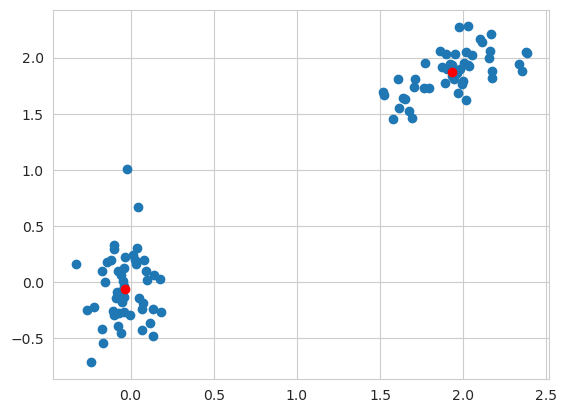

In [69]:
# Create 50 datapoints in two clusters a and b
pts = 50
rng = np.random.default_rng()
a = rng.multivariate_normal([0, 0], [[4, 1], [1, 4]], size=pts)
b = rng.multivariate_normal([30, 10],
                            [[10, 2], [2, 1]],
                            size=pts)
features = np.concatenate((a, b))
# Whiten data
whitened = whiten(features)
# Find 2 clusters in the data
codebook, distortion = kmeans(whitened, 2)
# Plot whitened data and cluster centers in re
plt.scatter(whitened[:, 0], whitened[:, 1])
plt.scatter(codebook[:, 0], codebook[:, 1], c='r')
plt.show()

The K-means algorithm is searching for the clusters configuration regarding the cost function minimization. Same was hapening in simulated annealing search method which was searching for the best blocks condiguration regarding to the Likelihood Maximization. The loss function for the K-means is the sum of squared distances to the cluster centroids where the point is assigned. When each point has its own cluster it`s loss function is 0. Same happened here for the assigning node in individual cluster.